In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
!pip install gensim
!pip install pyLDAvis
clear_output(wait=True)

print("Installed gensim, pyLDAvis")

Installed gensim, pyLDAvis


In [3]:
!pip install nltk

In [4]:
!pip install spacy --user

!python3 -m spacy download en_core_web_sm
clear_output(wait=True)

print("Downloaded spacy curpus")

Downloaded spacy curpus


In [5]:
!pip install pandarallel

clear_output(wait=True)

In [6]:
!pip install --upgrade numpy

In [7]:
import nltk as nltk
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [8]:
!pip install --upgrade nltk
!pip install --upgrade gensim

In [9]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

clear_output(wait=True)

print("Loaded spacy without parser, NER")

Loaded spacy without parser, NER


In [10]:
from pandarallel import pandarallel
import multiprocessing
num_processors = multiprocessing.cpu_count()
workers = num_processors-1
print(f'Available CPUs: {num_processors}')

Available CPUs: 16


In [11]:
import os
os.environ["GCLOUD_PROJECT"] = "sonorous-reach-380221"

In [14]:
df = pd.read_csv('df_news_recomb.csv')
df.head(2)

,token_text
0,artificial intelligence improves parking effic...
1,child autism saw learning social skill boosted...


In [15]:
def news_tokenize(text):
    
    import nltk
    
    #Tokenize
    tokens = nltk.word_tokenize(text)
    
    return tokens

In [16]:
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [17]:
# nltk.download('punkt')

In [19]:
df['tokens'] = df['token_text'].parallel_apply(news_tokenize)
df.head()

,token_text,tokens
0,artificial intelligence improves parking effic...,"[artificial, intelligence, improves, parking, ..."
1,child autism saw learning social skill boosted...,"[child, autism, saw, learning, social, skill, ..."
2,forget ml ai industry obsolescence focus test ...,"[forget, ml, ai, industry, obsolescence, focus..."
3,strategy analytics smartphones sold globally a...,"[strategy, analytics, smartphones, sold, globa..."
4,olympus support endoscopic ai diagnosis educat...,"[olympus, support, endoscopic, ai, diagnosis, ..."


In [25]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
news_text_dictionary = corpora.Dictionary(df['tokens']) #df_news_sample["tokens"])

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
news_text_doc_term_matrix = [news_text_dictionary.doc2bow(text) for text in df['tokens']] #df_news_sample["tokens"]]

print(f'Number of unique tokens: {len(news_text_dictionary)}')
print(f'Number of documents: {len(news_text_doc_term_matrix)}')

Number of unique tokens: 309486
Number of documents: 152522
CPU times: user 59.9 s, sys: 947 ms, total: 1min
Wall time: 1min


In [26]:
%%time

lda_model = LdaMulticore(corpus=news_text_doc_term_matrix,
                   id2word=news_text_dictionary,
                   num_topics=10,
                   random_state=100,
                   passes=10,
                   eta='auto',
                   workers=workers)

CPU times: user 2min 53s, sys: 15.2 s, total: 3min 8s
Wall time: 3min 2s


In [27]:
coherence_model_lda = CoherenceModel(model=lda_model, texts = df['tokens'], dictionary=news_text_dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_model_lda.get_coherence())


Coherence Score:  0.4592429961697757


In [28]:
print(*lda_model.print_topics(num_topics = 10, num_words = 7), sep='\n\n')

(0, '0.010*"newswires" + 0.006*"country" + 0.006*"crypto" + 0.006*"news" + 0.006*"republic" + 0.006*"industry" + 0.005*"international"')

(1, '0.027*"ai" + 0.011*"learning" + 0.011*"machine" + 0.008*"product" + 0.007*"follow" + 0.006*"share" + 0.006*"venturebeat"')

(2, '0.023*"news" + 0.019*"business" + 0.016*"service" + 0.013*"technology" + 0.011*"financial" + 0.010*"entertainment" + 0.009*"real"')

(3, '0.019*"news" + 0.010*"business" + 0.009*"ai" + 0.007*"market" + 0.007*"best" + 0.007*"review" + 0.007*"tech"')

(4, '0.032*"news" + 0.013*"search" + 0.012*"schedule" + 0.009*"business" + 0.008*"music" + 0.007*"local" + 0.007*"program"')

(5, '0.031*"ai" + 0.012*"data" + 0.009*"solution" + 0.008*"platform" + 0.008*"technology" + 0.007*"company" + 0.007*"customer"')

(6, '0.021*"ai" + 0.011*"chatgpt" + 0.010*"new" + 0.007*"google" + 0.005*"news" + 0.005*"company" + 0.005*"said"')

(7, '0.020*"ai" + 0.013*"data" + 0.012*"intelligence" + 0.010*"artificial" + 0.010*"technology" + 0.008*"s

In [31]:
def compute_coherence_values(doc_term_matrix, dictionary, k, a, b, text, coherence = 'c_v'):
    
    lda_model = LdaMulticore(corpus = doc_term_matrix,
                       id2word = dictionary,
                       num_topics = k,
                       random_state = 100,                  
                       passes = 10,
                       alpha = a,
                       eta = b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model = lda_model,
                                         texts=text,
                                         dictionary = dictionary,
                                         coherence=coherence)
    
    return coherence_model_lda.get_coherence()

import time 
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,
                                                                                                  t_min,t_sec))

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 4
max_topics = 20
step_size = 2
topics_range = range(min_topics, max_topics+1, step_size)

alpha = ['asymmetric'] 

beta = ['auto']

# Validation sets
num_of_docs = len(news_text_doc_term_matrix)
corpus_sets = [news_text_doc_term_matrix]

corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(doc_term_matrix = corpus_sets[i],
                                              dictionary = news_text_dictionary, 
                                              k=k, a=a, b=b,
                                              text = df['tokens'],
                                              coherence = 'c_v')
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()

LDA will execute 9 iterations
Completed model based on 4 LDA topics. Finished 11.1% of LDA runs
Execution time to calculate for topic 4: 0hour:3min:42sec
Completed model based on 6 LDA topics. Finished 22.2% of LDA runs
Execution time to calculate for topic 6: 0hour:4min:2sec
Completed model based on 8 LDA topics. Finished 33.3% of LDA runs
Execution time to calculate for topic 8: 0hour:4min:15sec
Completed model based on 10 LDA topics. Finished 44.4% of LDA runs
Execution time to calculate for topic 10: 0hour:4min:33sec
Completed model based on 12 LDA topics. Finished 55.6% of LDA runs
Execution time to calculate for topic 12: 0hour:4min:55sec
Completed model based on 14 LDA topics. Finished 66.7% of LDA runs
Execution time to calculate for topic 14: 0hour:5min:14sec
Completed model based on 16 LDA topics. Finished 77.8% of LDA runs
Execution time to calculate for topic 16: 0hour:5min:29sec
Completed model based on 18 LDA topics. Finished 88.9% of LDA runs
Execution time to calculate 

In [32]:
lda_tuning = pd.DataFrame(model_results)
lda_tuning.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence
7,18,asymmetric,auto,0.480078
6,16,asymmetric,auto,0.472296
8,20,asymmetric,auto,0.471578
5,14,asymmetric,auto,0.465314
4,12,asymmetric,auto,0.459886
1,6,asymmetric,auto,0.457580
3,10,asymmetric,auto,0.454408
2,8,asymmetric,auto,0.449034
0,4,asymmetric,auto,0.419193


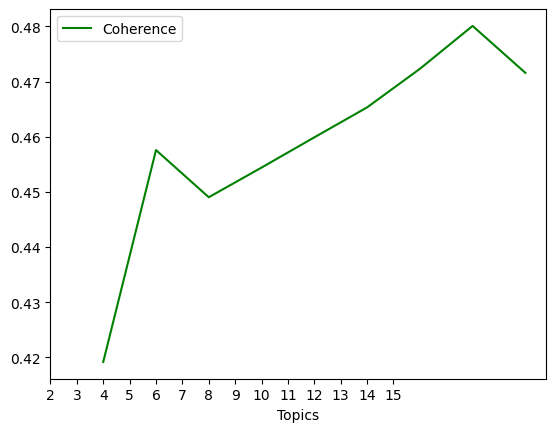

In [33]:
lda_tuning.plot(x ='Topics', y='Coherence', kind = 'line', xticks=range(2,16), color = 'green')
plt.grid(False)
plt.show()

In [41]:
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 18
max_topics = 18
step_size = 2
topics_range = range(min_topics, max_topics+1, step_size)

# # Alpha parameter
alpha = list(np.arange(0.01, 1, 0.495))
alpha.append('symmetric')
alpha.append('asymmetric')
# alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
beta = list(np.arange(0.01, 1, 0.495))
beta.append('symmetric')
# beta = ['auto'] # Run for number of topics only

# Validation sets
num_of_docs = len(news_text_doc_term_matrix)
corpus_sets = [news_text_doc_term_matrix]

corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(doc_term_matrix = corpus_sets[i],
                                              dictionary = news_text_dictionary, 
                                              k=k, a=a, b=b,
                                              text = df['tokens'],
                                              coherence = 'c_v')
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()

LDA will execute 12 iterations
Completed model based on 18 LDA topics. Finished 100.0% of LDA runs
Execution time to calculate for topic 18: 1hour:8min:23sec
CPU times: user 42min 48s, sys: 6min 36s, total: 49min 25s
Wall time: 1h 8min 23s


In [42]:
lda_tuning = pd.DataFrame(model_results)
lda_tuning.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence
5,18,0.505,symmetric,0.494073
11,18,asymmetric,symmetric,0.493805
9,18,asymmetric,0.01,0.491276
3,18,0.505,0.01,0.491111
2,18,0.01,symmetric,0.486712
4,18,0.505,0.505,0.486615
10,18,asymmetric,0.505,0.485416
6,18,symmetric,0.01,0.484704
0,18,0.01,0.01,0.478243
8,18,symmetric,symmetric,0.478135


In [44]:
lda_tuning_best = lda_tuning.sort_values(by=['Coherence'], ascending=False).head(1)

tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))

# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 18, Alpha: 0.505, Beta: symmetric


In [ ]:
%%time

tuned_ldamodel_news_text = LdaMulticore(corpus = news_text_doc_term_matrix,
                                      id2word = news_text_dictionary,
                                      num_topics=tuned_topics,
                                      random_state=100,
                                      passes=10,
                                      alpha=tuned_alpha,
                                      eta=tuned_beta,
                                      workers=workers)

coherence_model_lda = CoherenceModel(model=tuned_ldamodel_news_text, texts = df['tokens'], dictionary=news_text_dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_model_lda.get_coherence())

In [ ]:
print(*tuned_ldamodel_news_text.print_topics(num_topics = tuned_topics, num_words = 10), sep='\n\n')

In [ ]:
lda_tuning_best = lda_tuning.sort_values(by=['Coherence'], ascending=False)[1:2]

tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))

# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

In [49]:
%%time

tuned_ldamodel_news_text = LdaMulticore(corpus = news_text_doc_term_matrix,
                                      id2word = news_text_dictionary,
                                      num_topics=tuned_topics,
                                      random_state=100,
                                      passes=10,
                                      alpha=tuned_alpha,
                                      eta=tuned_beta,
                                      workers=workers)

coherence_model_lda = CoherenceModel(model=tuned_ldamodel_news_text, texts = df['tokens'], dictionary=news_text_dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_model_lda.get_coherence())


Coherence Score:  0.49714951867874063
CPU times: user 3min 45s, sys: 35.2 s, total: 4min 20s
Wall time: 5min 54s


In [50]:
print(*tuned_ldamodel_news_text.print_topics(num_topics = tuned_topics, num_words = 10), sep='\n\n')

(0, '0.012*"newswires" + 0.009*"news" + 0.008*"country" + 0.007*"republic" + 0.007*"industry" + 0.007*"ai" + 0.006*"international" + 0.006*"medium" + 0.006*"distribution" + 0.005*"music"')

(1, '0.031*"ai" + 0.011*"product" + 0.010*"language" + 0.009*"model" + 0.007*"generative" + 0.007*"new" + 0.007*"user" + 0.007*"chatgpt" + 0.006*"technology" + 0.006*"tool"')

(2, '0.014*"news" + 0.009*"ai" + 0.009*"intelligence" + 0.008*"artificial" + 0.008*"world" + 0.007*"photo" + 0.007*"business" + 0.007*"video" + 0.007*"submit" + 0.006*"bc"')

(3, '0.036*"data" + 0.011*"science" + 0.010*"business" + 0.010*"ai" + 0.010*"learning" + 0.008*"machine" + 0.006*"icon" + 0.006*"news" + 0.006*"company" + 0.005*"intelligence"')

(4, '0.034*"news" + 0.015*"schedule" + 0.014*"music" + 0.013*"radio" + 0.013*"search" + 0.012*"program" + 0.009*"public" + 0.008*"event" + 0.008*"air" + 0.008*"contact"')

(5, '0.034*"ai" + 0.012*"data" + 0.011*"solution" + 0.009*"platform" + 0.007*"technology" + 0.007*"company" 

In [51]:
lda_tuning_best = lda_tuning.sort_values(by=['Coherence'], ascending=False)[2:3]

tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))

# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 18, Alpha: asymmetric, Beta: 0.01


In [52]:
%%time

tuned_ldamodel_news_text = LdaMulticore(corpus = news_text_doc_term_matrix,
                                      id2word = news_text_dictionary,
                                      num_topics=tuned_topics,
                                      random_state=100,
                                      passes=10,
                                      alpha=tuned_alpha,
                                      eta=tuned_beta,
                                      workers=workers)

coherence_model_lda = CoherenceModel(model=tuned_ldamodel_news_text, texts = df['tokens'], dictionary=news_text_dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_model_lda.get_coherence())


Coherence Score:  0.49033103719629906
CPU times: user 3min 44s, sys: 33.9 s, total: 4min 18s
Wall time: 5min 50s


In [53]:
print(*tuned_ldamodel_news_text.print_topics(num_topics = tuned_topics, num_words = 10), sep='\n\n')

(0, '0.012*"newswires" + 0.009*"news" + 0.008*"country" + 0.007*"republic" + 0.007*"ai" + 0.007*"industry" + 0.006*"international" + 0.006*"medium" + 0.006*"distribution" + 0.005*"island"')

(1, '0.031*"ai" + 0.011*"product" + 0.009*"language" + 0.009*"model" + 0.007*"generative" + 0.007*"new" + 0.006*"technology" + 0.006*"user" + 0.006*"chatgpt" + 0.006*"tool"')

(2, '0.014*"news" + 0.009*"ai" + 0.009*"intelligence" + 0.009*"artificial" + 0.008*"world" + 0.007*"video" + 0.007*"business" + 0.007*"photo" + 0.007*"submit" + 0.006*"bc"')

(3, '0.037*"data" + 0.012*"business" + 0.011*"science" + 0.009*"ai" + 0.007*"learning" + 0.007*"icon" + 0.007*"news" + 0.006*"company" + 0.006*"machine" + 0.005*"intelligence"')

(4, '0.034*"news" + 0.014*"schedule" + 0.014*"radio" + 0.014*"search" + 0.014*"music" + 0.012*"program" + 0.009*"public" + 0.008*"event" + 0.008*"air" + 0.008*"contact"')

(5, '0.034*"ai" + 0.012*"data" + 0.011*"solution" + 0.008*"platform" + 0.007*"technology" + 0.007*"company"